In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle 


import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from astropy.io import fits
from astropy.table import Table

from tqdm import tqdm
import os
import sys

%matplotlib inline

def mkdir(directory_path): 
    if os.path.exists(directory_path): 
        return directory_path
    else: 
        try: 
            os.makedirs(directory_path)
        except: 
            # in case another machine created the path meanwhile !:(
            return sys.exit("Erro ao criar diretório") 
        return directory_path


def open_fits_catalog(fits_file):
    hdu_list=fits.open(fits_file, ignore_missing_end=True)
    #print hdu_list
    hdu = hdu_list[1]    # table extensions can't be the first extension, so there's a dummy image extension at 0
    #print hdu.header
    cat_table = Table(hdu.data)
    cols=hdu.columns
    return cat_table

def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':'normal',
                        'font.size':22.0,
                        'text.color':'black',
                        'text.usetex':True,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.0,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':'x-large',
                        'axes.labelweight':'normal',
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':'medium',
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':7,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':'medium',
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        #'legend.fontsize':'x-large',
                        'legend.shadow':False,
                        'legend.frameon':False})
    
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [13]:
test_pdfs = np.load('test_data/fold_0/my_pdfs.npy')
my_alphas = np.load('test_data/fold_0/my_alphas.npy')
my_mus = np.load('test_data/fold_0/my_mus.npy')
my_sigmas = np.load('test_data/fold_0/my_sigmas.npy')
my_phz = np.load('test_data/fold_0/my_photoz.npy')
my_zerr = np.load('test_data/fold_0/my_zerr.npy')

In [26]:
ORIGINAL_PATH = 'test_data/'
DECODED_PATH = 'results/'

TEST_PATH = 'test_data/DELVE_DR2_test_flat_GRIZ.csv'

TEST_DATA = pd.read_csv(TEST_PATH)

N_FOLDS = 5
ZAXIS=np.linspace(0,2,2000)
SCALER = StandardScaler()

My_Photoz = {}
My_PDFs = {}
My_Errors = {}

My_Alphas = {}
My_Mus = {}
My_Sigmas = {}

My_Photoz['original'] = {}
My_PDFs['original'] = {}
My_Errors['original'] = {}

My_Alphas['original'] = {}
My_Mus['original'] = {}
My_Sigmas['original'] = {}

My_Photoz['decoded'] = {}
My_PDFs['decoded'] = {}
My_Errors['decoded'] = {}

My_Alphas['decoded'] = {}
My_Mus['decoded'] = {}
My_Sigmas['decoded'] = {}

fold = [f'fold_{j}' for j in range(N_FOLDS)]
j_fake = 0
for j in tqdm(range(N_FOLDS)[:1]):
    My_PDFs[fold[j]] = {}
    My_Photoz[fold[j]] = {}
    My_Errors[fold[j]] = {}

    My_Alphas[fold[j]] = {}
    My_Mus[fold[j]] = {}
    My_Sigmas[fold[j]] = {}

    My_PDFs['original'][fold[j]] = np.load(ORIGINAL_PATH + fold[j_fake] + '/' + 'my_pdfs.npy')
    My_Photoz['original'][fold[j]] = np.load(ORIGINAL_PATH + fold[j_fake] + '/' + 'my_photoz.npy')
    My_Errors['original'][fold[j]] = np.load(ORIGINAL_PATH + fold[j_fake] + '/' + 'my_zerr.npy')

    My_PDFs['decoded'][fold[j]] = np.load(DECODED_PATH + fold[j] + '/' + 'my_pdfs.npy')
    My_Photoz['decoded'][fold[j]] = np.load(DECODED_PATH + fold[j] + '/' + 'my_photoz.npy')
    My_Errors['decoded'][fold[j]] = np.load(DECODED_PATH + fold[j] + '/' + 'my_zerr.npy')

    My_Alphas['original'][fold[j]] = np.load(ORIGINAL_PATH + fold[j_fake] + '/' + 'my_alphas.npy')
    My_Mus['original'][fold[j]] = np.load(ORIGINAL_PATH + fold[j_fake] + '/' + 'my_mus.npy')
    My_Sigmas['original'][fold[j]] = np.load(ORIGINAL_PATH + fold[j_fake] + '/' + 'my_sigmas.npy')

    My_Alphas['decoded'][fold[j]] = np.load(DECODED_PATH + fold[j] + '/' + 'my_alphas.npy')
    My_Mus['decoded'][fold[j]] = np.load(DECODED_PATH + fold[j] + '/' + 'my_mus.npy')
    My_Sigmas['decoded'][fold[j]] = np.load(DECODED_PATH + fold[j] + '/' + 'my_sigmas.npy')

  0%|                                                                                                                                 | 0/1 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'results/fold_0/my_pdfs.npy'

In [3]:
def h2dplot(x, y, ax=None, nbins=50, size=.5, alpha=.5, marker='.'):


    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = nbins)

    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data ,
                np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    cax=ax.scatter( x, y, c=z,s=size,alpha=alpha, marker=marker)

    return ax, cax 

def metrics_per_bin(zspec, zphot, zwidth,rmag=None,
                    magwidth=None,xaxis='zspec', zlims=(0,1), maglims=None):
    
    
    Bins_Z   = np.arange(zlims[0], zlims[1]+zwidth, zwidth)
    
    if xaxis=='rmag':
        if not maglims:
            Bins_Z   = np.arange(np.min(rmag), np.max(rmag)+magwidth, magwidth)
        else:
            Bins_Z   = np.arange(maglims[0], maglims[1]+magwidth, magwidth)

    metrics_list = ['$\sigma_{NMAD}$','mean bias', 'median bias', 'outfrac']#, 's68']
    
    metrics = {}
    for m in metrics_list:
        metrics[m] = []
    
    for bin_val in Bins_Z:
        
        if xaxis=='zspec':
            between = (zspec>=bin_val) & (zspec<bin_val+zwidth)
            
        elif xaxis=='zphot':
            between = (zphot>=bin_val) & (zphot<bin_val+zwidth)
            
        elif xaxis=='rmag':
            between = (rmag>=bin_val) & (rmag<bin_val+zwidth)
        
        zspec_bin = zspec[between]
        zphot_bin = zphot[between]

        delta_z = zphot_bin - zspec_bin#zspec_bin - zphot_bin
        
        snmad = 1.48 * np.median(np.absolute(delta_z - np.median(delta_z)) / (1+zspec_bin))
        #https://iopscience.iop.org/article/10.1086/591786/pdf
        
        mean_bias = np.mean(delta_z, axis=0)

        median_bias = np.median(delta_z)

        outlier_frac_point = np.sum(  np.abs(delta_z)/(1+zspec_bin) >0.15)/len(delta_z)
        
        # p16 = np.percentile(delta_z, 15.9)
        # p84 = np.percentile(delta_z, 84.1)
        # s68 = (p84-p16)/2
        
        
        metrics['$\sigma_{NMAD}$'].append(snmad)
        metrics['mean bias'].append(mean_bias)
        metrics['median bias'].append(median_bias)
        metrics['outfrac'].append(outlier_frac_point)
        # metrics['s68'].append(s68)
    
    return metrics, Bins_Z


In [4]:
My_Metrics = {}
My_Bins = {}

My_Metrics['original'] = {}
My_Bins['original'] = {}

My_Metrics['decoded'] = {}
My_Bins['decoded'] = {}

possible_axis = ['zspec','zphot','rmag']


for xaxis in possible_axis:

    My_Metrics['original'][xaxis] = {}
    My_Bins['original'] [xaxis] = {}

    My_Metrics['decoded'][xaxis] = {}
    My_Bins['decoded'] [xaxis] = {}
    
    for j in range(N_FOLDS)[:1]:
        print(fold[j].upper())

        My_Metrics['original'][xaxis][fold[j]], My_Bins['original'][xaxis] = metrics_per_bin(TEST_DATA['Z'],
                                                                                                My_Photoz['original'][fold[j]],
                                                                                                zwidth=.05,
                                                                                                rmag=TEST_DATA['MAG_AUTO_R'],
                                                                                                magwidth=0.1,
                                                                                                xaxis=xaxis, 
                                                                                                zlims=(0.01,1),
                                                                                                maglims=(16,22.5))
        
        My_Metrics['decoded'][xaxis][fold[j]], My_Bins['decoded'][xaxis] = metrics_per_bin(TEST_DATA['Z'],
                                                                                                My_Photoz['decoded'][fold[j]],
                                                                                                zwidth=.05,
                                                                                                rmag=TEST_DATA['MAG_AUTO_R'],
                                                                                                magwidth=0.1,
                                                                                                xaxis=xaxis, 
                                                                                                zlims=(0.01,1),
                                                                                                maglims=(16,22.5))
                                                                                                
                                                                                               
Metric_Mean = {}
Metric_Std = {}

Metric_Mean['original'] = {}
Metric_Std['original'] = {}

Metric_Mean['decoded'] = {}
Metric_Std['decoded'] = {}

for xaxis in possible_axis:

    Metric_Mean['original'][xaxis] = {}
    Metric_Std['original'][xaxis] = {}

    Metric_Mean['decoded'][xaxis] = {}
    Metric_Std['decoded'][xaxis] = {}

    for xn in My_Metrics['original']['zspec'][fold[0]]:

        aux_list_ori = [My_Metrics['original'][xaxis][fold[j]][xn] for j in range(N_FOLDS)[:1]]
        aux_list_dec = [My_Metrics['decoded'][xaxis][fold[j]][xn] for j in range(N_FOLDS)[:1]]

        Metric_Mean['original'][xaxis][xn] = np.mean(np.vstack(aux_list_ori), axis=0)
        Metric_Mean['decoded'][xaxis][xn] = np.mean(np.vstack(aux_list_dec), axis=0)

        Metric_Std['original'][xaxis][xn] = np.std(np.vstack(aux_list_ori), axis=0)
        Metric_Std['decoded'][xaxis][xn] = np.std(np.vstack(aux_list_dec), axis=0)

    





FOLD_0
FOLD_0
FOLD_0


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_154286/2937962283.py:59: RuntimeWarning: invalid value encountered in scalar divide
  outlier_frac_point = np.sum(  np.abs(delta_z)/(1+zspec_bin) >0.15)/len(delta_z)


In [5]:
def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':750,
                        'font.size':22.0,
                        'text.color':'black',
                        'text.usetex':True,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.50,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':36,
                        # 'axes.labelweight':750,
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':30,
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':9,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':30,
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        'legend.fontsize':36,
                        'legend.shadow':False,
                        'legend.frameon':False})

mpl.rcdefaults()

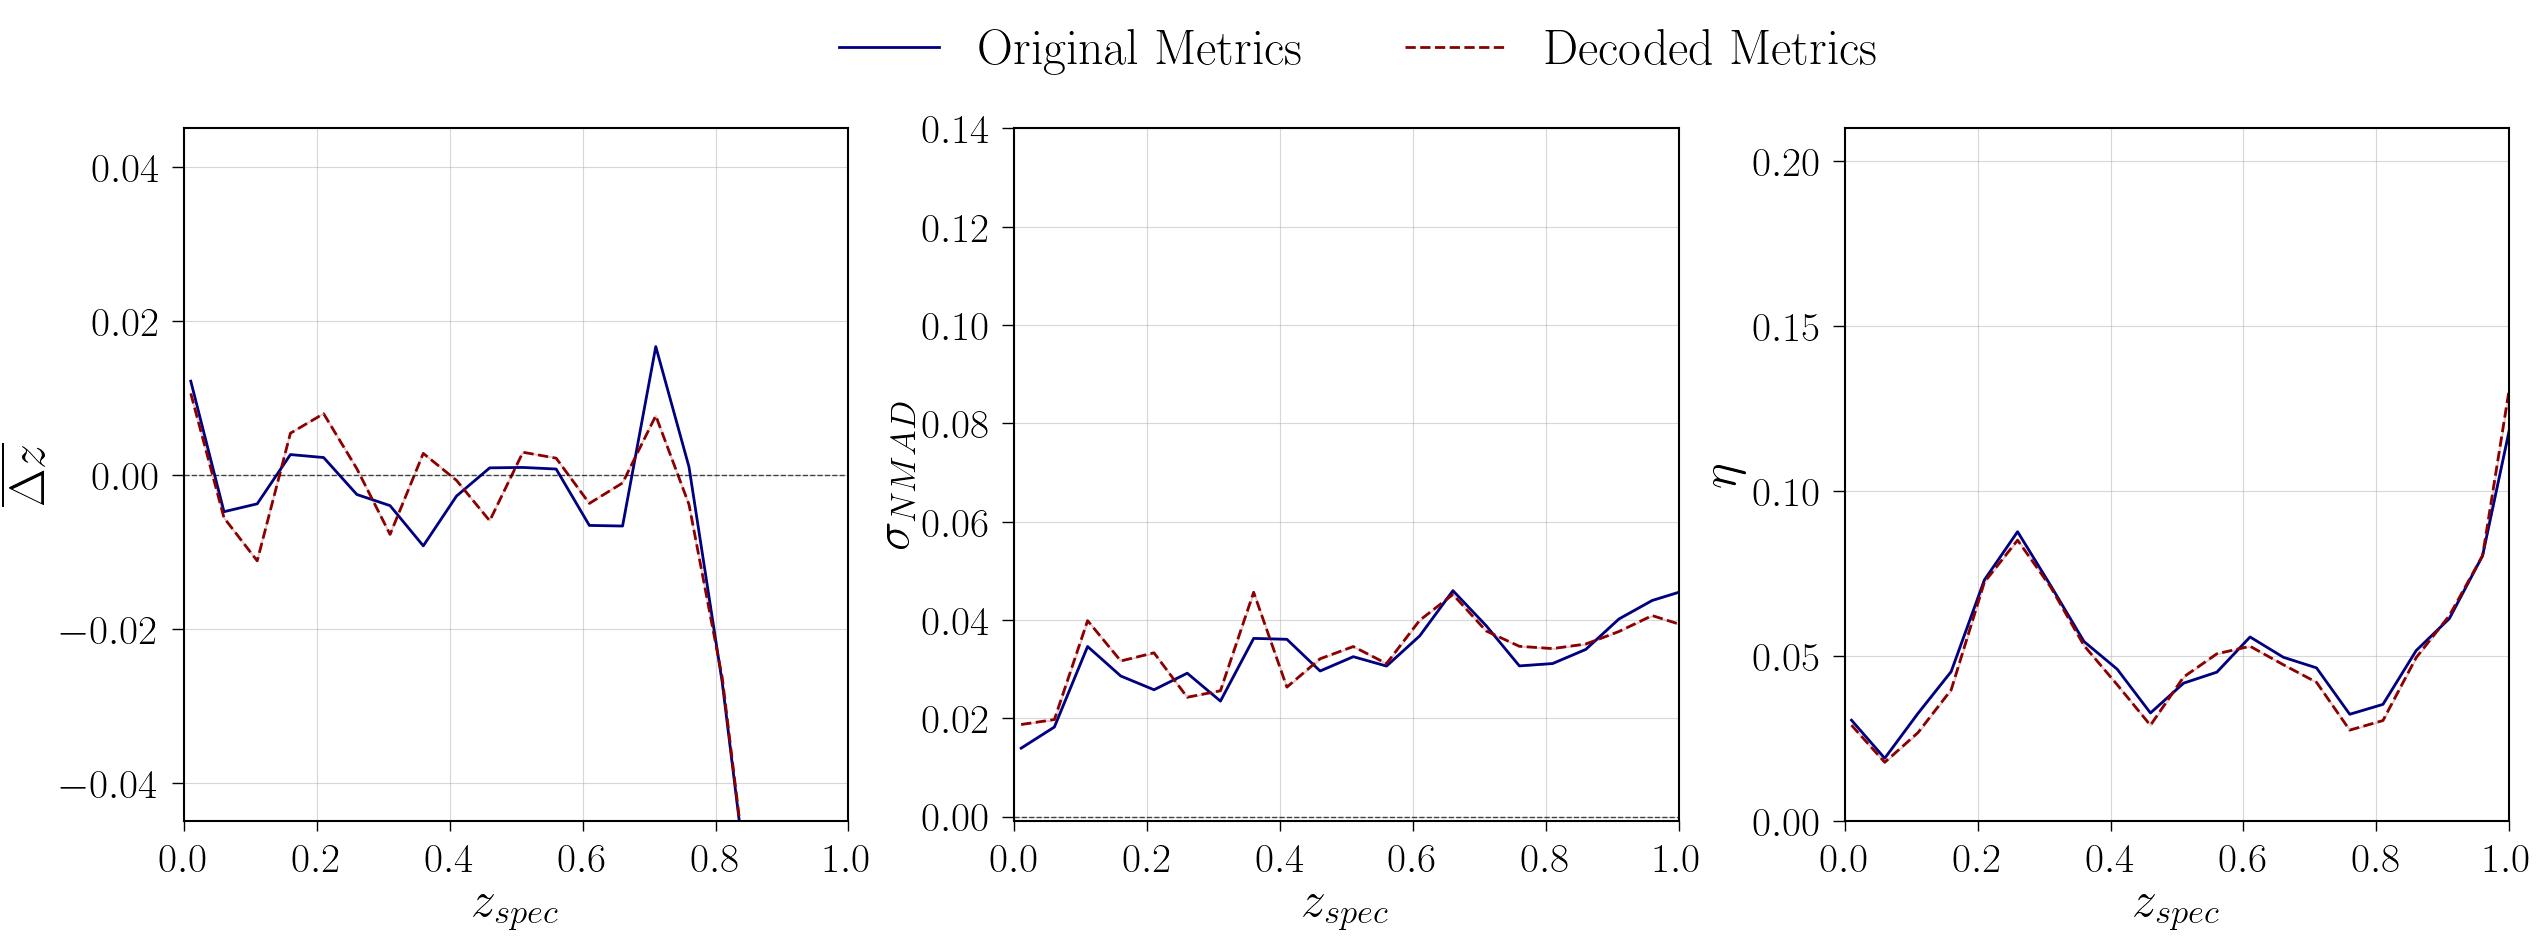

In [6]:
xaxis = 'zspec'
mpl.rcdefaults()
plt_style()
fig, axs = plt.subplots(figsize=(30,9), dpi=100, nrows=1, ncols=3)
plt.subplots_adjust(wspace=.25)
# plt.rcParams.update({
#                     'font.family':'serif',
#                     'font.weight':'normal',
#                     'font.size':22.0,
#                     'axes.linewidth':3,
#                     'axes.labelsize':20,
#                     'axes.labelweight':'normal',
#                     # 'xtick.labelsize':30,
#                     # 'ytick.labelsize':30,
#                     'legend.numpoints':1,
#                     'legend.fontsize':22,})

shadow_alpha = .2

original_style = {'color':'navy',
               'ls':'-',
               'lw':2,
               'label':'Original Metrics'}

decoded_style = {'color':'darkred',
               'ls':'--',
               'lw':2,
               'label':'Decoded Metrics'}

######################################### MEDIAN BIAS ############################################################

ax = axs[0]
metric = 'median bias'

ax.plot(My_Bins['original'][xaxis], Metric_Mean['original'][xaxis][metric], **original_style)
ax.fill_between(My_Bins['decoded'][xaxis], 
                Metric_Mean['original'][xaxis][metric]-Metric_Std['original'][xaxis][metric],
                Metric_Mean['original'][xaxis][metric]+Metric_Std['original'][xaxis][metric], color=original_style['color'], alpha=shadow_alpha)


ax.plot(My_Bins['decoded'][xaxis], Metric_Mean['decoded'][xaxis][metric], **decoded_style)
ax.fill_between(My_Bins['decoded'][xaxis], 
                Metric_Mean['decoded'][xaxis][metric]-Metric_Std['decoded'][xaxis][metric],
                Metric_Mean['decoded'][xaxis][metric]+Metric_Std['decoded'][xaxis][metric], color=decoded_style['color'], alpha=shadow_alpha)



ax.grid(alpha=.5)
ax.set_xlim(0.0,1)
ax.set_ylim(-0.015*3,0.015*3)
ax.axhline(0, c='black', ls='--', alpha=.7)
ax.set_ylabel('$\overline{\\Delta z}$')
ax.set_xlabel('$z_{spec}$',)
# ax.tick_params(axis='both', which='major')
# ax.tick_params(axis='y', which='minor')
# ax.set_title('no WISE', fontsize=16)
# plt.legend(fontsize=16)


######################################### SIGMA NMAD ############################################################

ax = axs[1]
metric = '$\sigma_{NMAD}$'

ax.plot(My_Bins['original'][xaxis], Metric_Mean['original'][xaxis][metric], **original_style)
ax.fill_between(My_Bins['decoded'][xaxis], 
                Metric_Mean['original'][xaxis][metric]-Metric_Std['original'][xaxis][metric],
                Metric_Mean['original'][xaxis][metric]+Metric_Std['original'][xaxis][metric], color=original_style['color'], alpha=shadow_alpha)


ax.plot(My_Bins['decoded'][xaxis], Metric_Mean['decoded'][xaxis][metric], **decoded_style)
ax.fill_between(My_Bins['decoded'][xaxis], 
                Metric_Mean['decoded'][xaxis][metric]-Metric_Std['decoded'][xaxis][metric],
                Metric_Mean['decoded'][xaxis][metric]+Metric_Std['decoded'][xaxis][metric], color=decoded_style['color'], alpha=shadow_alpha)


ax.grid(alpha=.5)
ax.set_xlim(0.0,1)
ax.set_ylim(-0.001,0.14)
ax.axhline(0, c='black', ls='--', alpha=.7)
ax.set_ylabel('$\sigma_{NMAD}$',)
ax.set_xlabel('$z_{spec}$',)
# ax.tick_params(axis='both', which='major',)
# ax.tick_params(axis='y', which='minor',)
# ax.set_title('no WISE', fontsize=16)
# plt.legend(fontsize=16)

######################################### OUT. FRAC ############################################################

ax = axs[2]
metric = 'outfrac'
ax.plot(My_Bins['original'][xaxis], Metric_Mean['original'][xaxis][metric], **original_style)
ax.fill_between(My_Bins['decoded'][xaxis], 
                Metric_Mean['original'][xaxis][metric]-Metric_Std['original'][xaxis][metric],
                Metric_Mean['original'][xaxis][metric]+Metric_Std['original'][xaxis][metric], color=original_style['color'], alpha=shadow_alpha)


ax.plot(My_Bins['decoded'][xaxis], Metric_Mean['decoded'][xaxis][metric], **decoded_style)
ax.fill_between(My_Bins['decoded'][xaxis], 
                Metric_Mean['decoded'][xaxis][metric]-Metric_Std['decoded'][xaxis][metric],
                Metric_Mean['decoded'][xaxis][metric]+Metric_Std['decoded'][xaxis][metric], color=decoded_style['color'], alpha=shadow_alpha)


ax.grid(alpha=.5)
ax.set_xlim(0.0,1)
ax.set_ylim(0,0.21)
ax.axhline(0, c='black', ls='--', alpha=.7)
ax.set_ylabel('$\eta$', )
ax.set_xlabel('$z_{spec}$', )
# ax.tick_params(axis='both', which='major', )
# ax.tick_params(axis='y', which='minor', )
# ax.set_title('no WISE', fontsize=16)
handles, labels = ax.get_legend_handles_labels()

lgd = fig.legend(handles, labels, frameon=False, ncol=len(labels),bbox_to_anchor=(.705
                                                                                  , 1.04))
# fig.get_tightbbox(fig.canvas.get_renderer())

# axs[1].annotate('AAAAQUI', xy=(.5,-0), xycoords='figure fraction', fontsize=28)
plt.savefig('results/metrics_decoded.pdf', bbox_inches='tight')

In [7]:
def h2dplot(x, y, ax=None, nbins=50, size=.5, alpha=.5):


    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = nbins)

    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data ,
                np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    cax = ax.scatter( x, y, c=z,s=size,alpha=alpha )

    # fig.colorbar(cax,ax=ax)
    # ax.set_ylabel('$z_{phot}$', fontsize=labelsize)#, fontsize=labelsize)
    # ax.set_xlabel('$z_{spec}$', fontsize=labelsize)#, fontsize=labelsize)
    return ax, cax 

def get_snmad(zspec, zphot):
    
    delta_z = zphot - zspec
    s = 1.48 * np.median(np.absolute(delta_z - np.median(delta_z)) / (1+zspec))
    return s

def get_median_bias(zspec, zphot):
    
    delta_z = zphot - zspec
    median_bias = np.median(delta_z)
    return median_bias

def get_outfrac(zspec, zphot):
    
    delta_z = zphot - zspec
    outlier_frac_point = np.sum(  np.abs(delta_z)/(1+zspec) > 0.15 ) /len(delta_z)
    return outlier_frac_point

Text(0.5, 0, 'n objects')

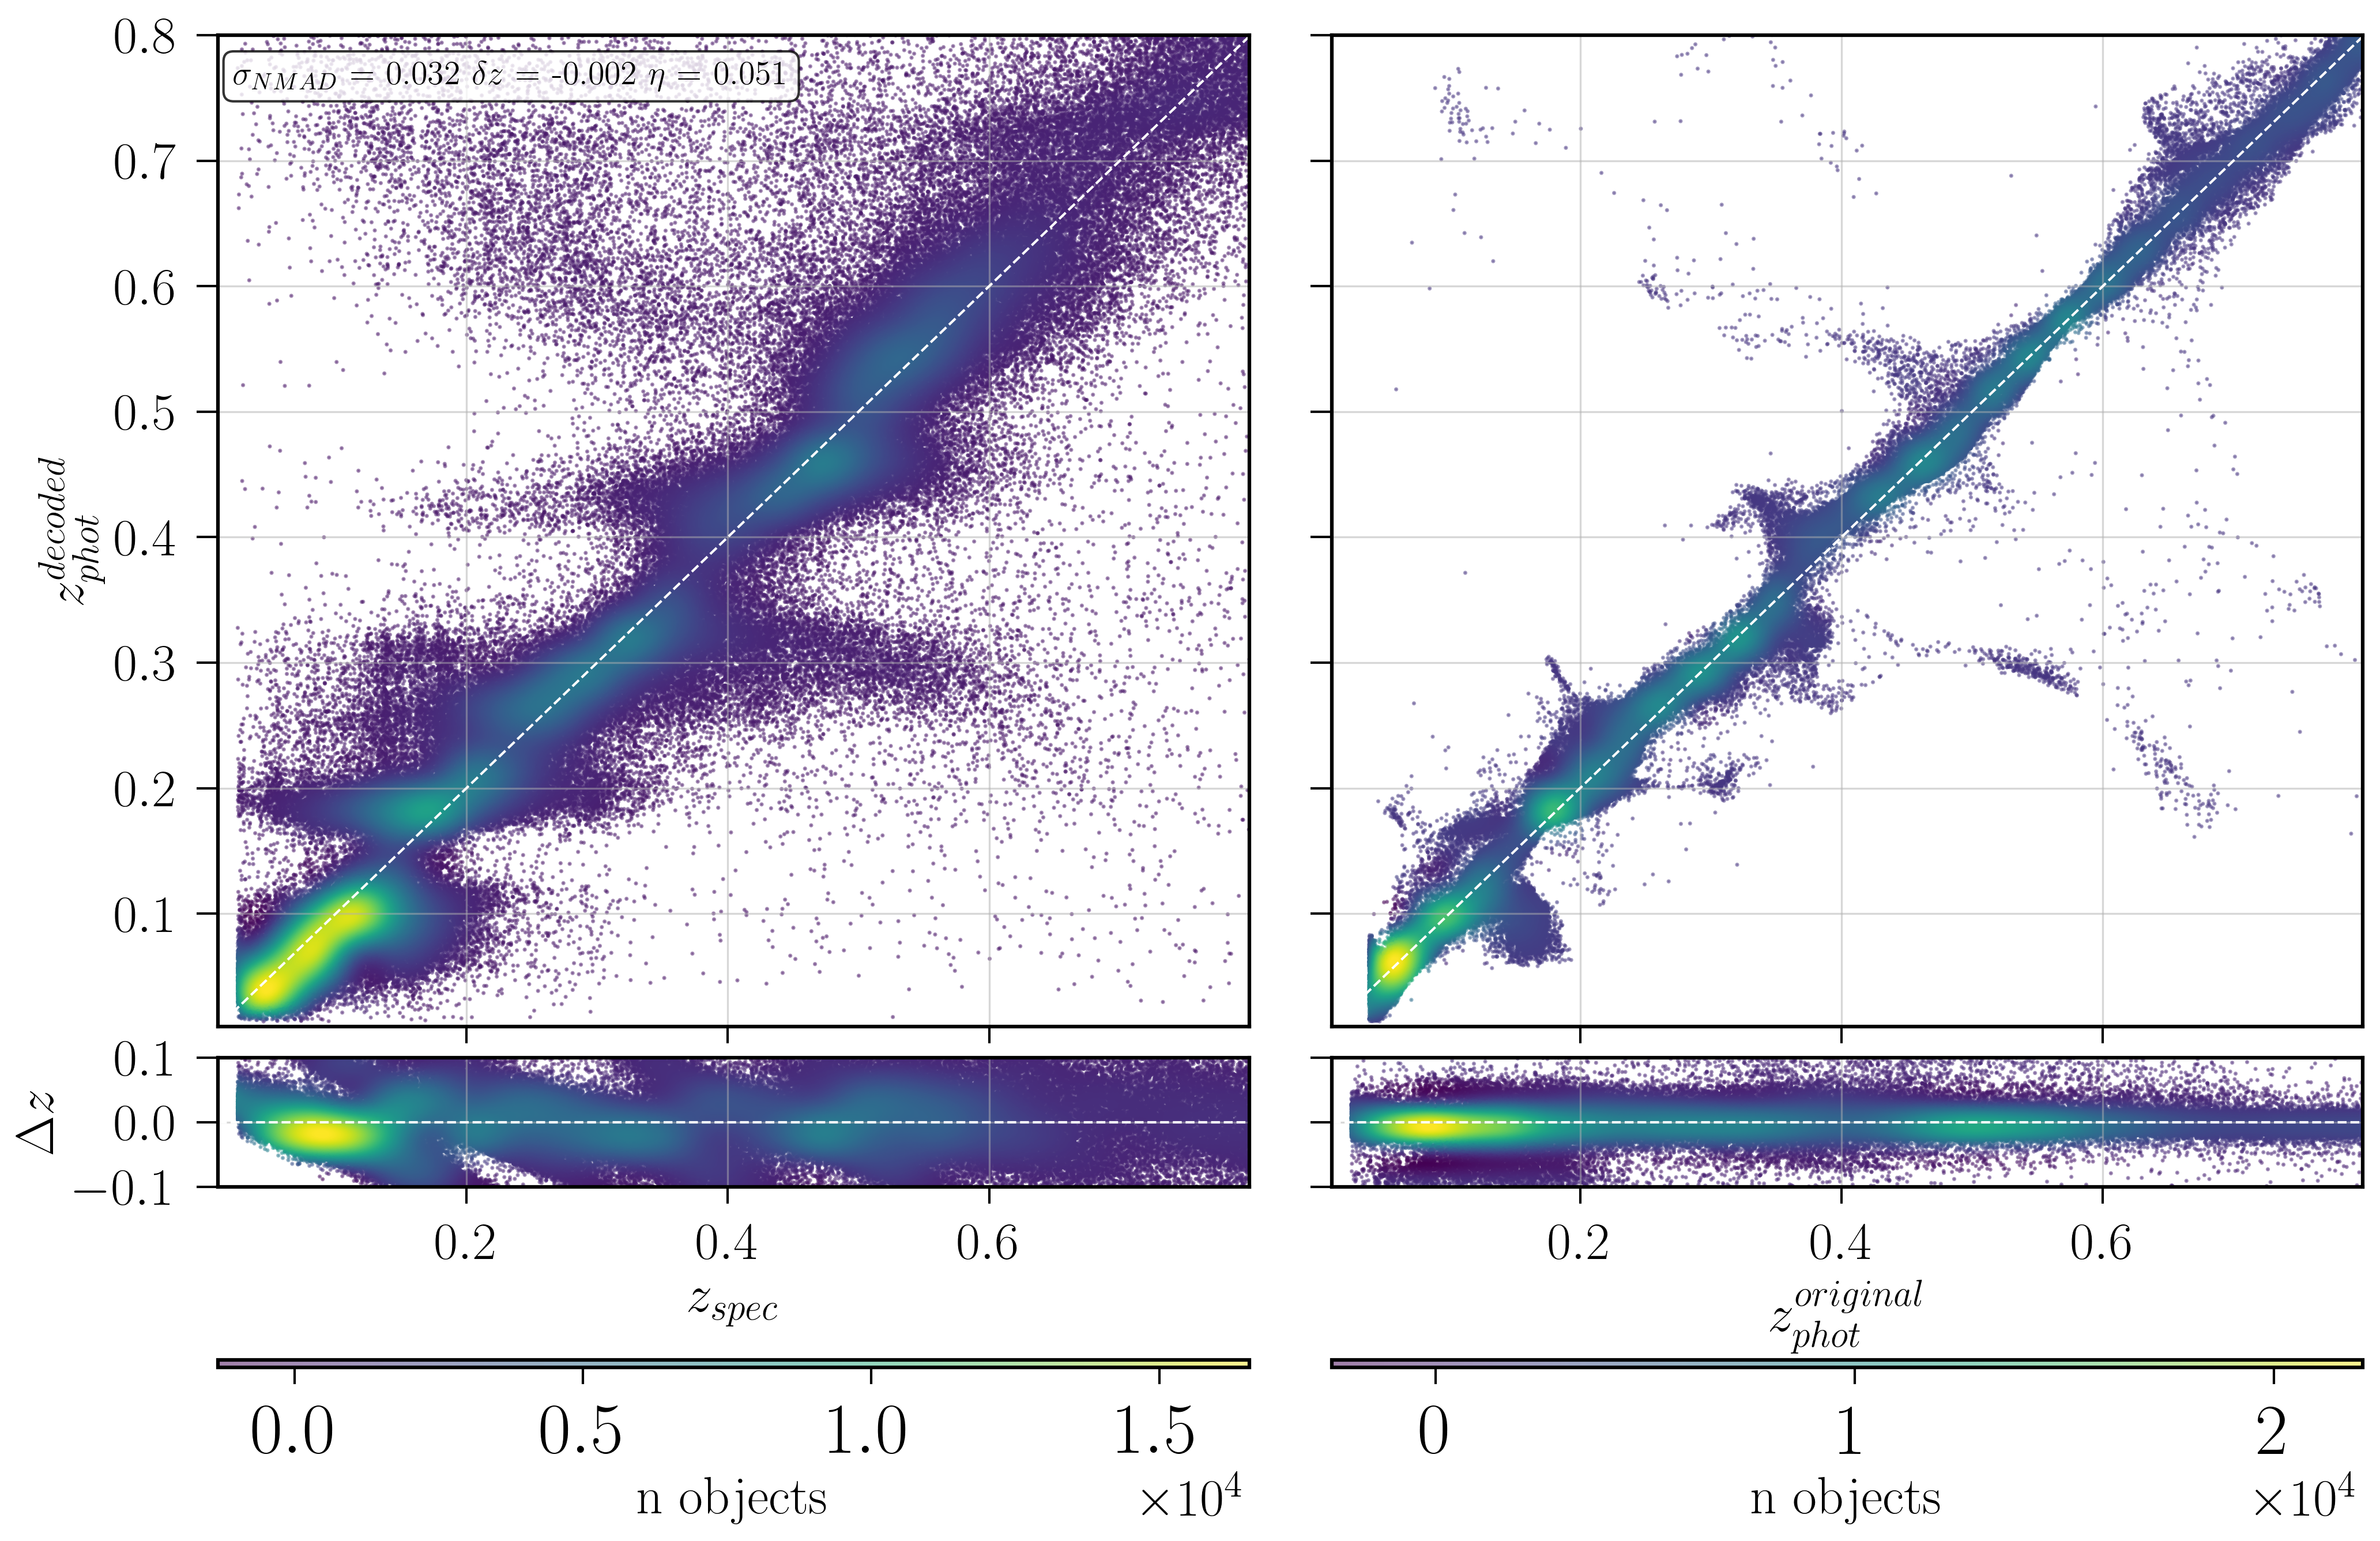

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
best_fold = fold[0]
# plt.rcParams['axes.labelsize'] = 22
labelsize=22
fig = plt.figure(figsize=(16, 10), dpi=300)
# fig = plt.figure(layout=None, facecolor='0.9')
gs = fig.add_gridspec(nrows=4, ncols=2, hspace=0.1, wspace=0.08)#left=0.05, right=0.75,
                      

zspec_toplot = np.array(TEST_DATA['Z'])
zphot_toplot = {}
zphot_toplot["original"] = My_Photoz["original"][best_fold]
zphot_toplot["decoded"] = My_Photoz["decoded"][best_fold]

rmag_toplot = TEST_DATA['MAG_AUTO_R']

sigma = {}
medianb = {}
outfrac = {}
ax_xy = {}
delta = {}
ax_delta = {}

surveys = [xn for xn in zphot_toplot]

for sn in surveys:
    sigma[sn] = get_snmad(zspec_toplot, zphot_toplot[sn])
    medianb[sn] = get_median_bias(zspec_toplot, zphot_toplot[sn])
    outfrac[sn] = get_outfrac(zspec_toplot, zphot_toplot[sn])
    delta[sn] = zphot_toplot[sn] - zspec_toplot

# ORIGINAL
ax_xy['left'] = fig.add_subplot(gs[:-1,0])
ax_xy['left'].set_ylabel('$z_{phot}^{decoded}$', fontsize=labelsize)
ax_delta['left'] = fig.add_subplot(gs[-1,0])
ax_delta['left'].set_ylabel('$\Delta z$', fontsize=labelsize)

# DECODED
ax_xy['right'] = fig.add_subplot(gs[:-1,1], sharey=ax_xy['left'])
ax_xy['right'].tick_params('y', labelleft=False)

ax_delta['right'] = fig.add_subplot(gs[-1,1], sharey=ax_delta['left'], sharex=ax_xy['right'])
ax_delta['right'].tick_params('y', labelleft=False)

########## DECODED VERSUS SPEC Z ############

# sn="original"
sn='left'
ax_xy[sn].annotate(f'$\sigma_{{NMAD}}$ = {sigma["decoded"]:.3f}  $\delta z$ = {medianb["decoded"]:.3f}  $\eta$ = {outfrac["decoded"]:.3f}',
               xy=[.015, .95],xycoords='axes fraction',
               bbox=dict(boxstyle="round", fc="white", alpha=.8),fontsize=14)
ax_xy[sn], cax = h2dplot(zspec_toplot,zphot_toplot["decoded"], ax=ax_xy[sn])




ax_xy[sn].tick_params('x', labelbottom=False)
ax_xy[sn].tick_params(axis='y', which='major', labelsize=labelsize)
ax_xy[sn].plot([0,1],[0,1], ls='--', color='white')
ax_xy[sn].set_xlim(0.01,0.799)
ax_xy[sn].set_ylim(0.01,0.8)
ax_xy[sn].grid(alpha=0.5)

ax_delta[sn], cax = h2dplot(zspec_toplot, delta["decoded"], ax=ax_delta[sn])
ax_delta[sn].set_xlabel('$z_{spec}$', fontsize=labelsize)
ax_delta[sn].set_xlim(0.01,0.799)
ax_delta[sn].axhline(ls='--', color='white')
# ax_delta.set_ylim(0,0.8)
ax_delta[sn].tick_params(axis='both', which='major', labelsize=labelsize)
ax_delta[sn].grid(alpha=.5)
ax_delta[sn].set_ylim(-0.1, 0.1)

divider = make_axes_locatable(ax_delta[sn])
cbaxes = divider.append_axes('bottom', size='6%', pad=1)

# cbaxes = fig.add_axes([0.05, 0.935, 0.335+0.4, 0.03])  
cb = plt.colorbar(cax, cax = cbaxes, orientation='horizontal')
cb.formatter.set_powerlimits((0, 0))
cbaxes.xaxis.offsetText.set_fontsize(labelsize)
cbaxes.set_xlabel('n objects', fontsize=labelsize)

########## DECODED VERSUS ORIGINAL ############

sn='right'
# ax_xy[sn].annotate(f'$\sigma_{{NMAD}}$ = {sigma["decoded"]:.3f}  $\delta z$ = {medianb["decoded"]:.3f}  $\eta$ = {outfrac["decoded"]:.3f}',
#                xy=[.015, .95],xycoords='axes fraction',
#                bbox=dict(boxstyle="round", fc="white", alpha=.8),fontsize=14)
ax_xy[sn], cax = h2dplot(zphot_toplot["original"],zphot_toplot["decoded"], ax=ax_xy[sn])




ax_xy[sn].tick_params('x', labelbottom=False)
ax_xy[sn].tick_params(axis='y', which='major', labelsize=labelsize)
ax_xy[sn].plot([0,1],[0,1], ls='--', color='white')
ax_xy[sn].set_xlim(0.01,0.799)
ax_xy[sn].set_ylim(0.01,0.8)
ax_xy[sn].grid(alpha=0.5)

ax_delta[sn], cax = h2dplot(zspec_toplot, zphot_toplot["decoded"] - zphot_toplot["original"], ax=ax_delta[sn])
ax_delta[sn].set_xlabel('$z_{phot}^{original}$', fontsize=labelsize)
ax_delta[sn].set_xlim(0.01,0.799)
ax_delta[sn].axhline(ls='--', color='white')
# ax_delta.set_ylim(0,0.8)
ax_delta[sn].tick_params(axis='both', which='major', labelsize=labelsize)
ax_delta[sn].grid(alpha=.5)
ax_delta[sn].set_ylim(-0.1, 0.1)

divider = make_axes_locatable(ax_delta[sn])
cbaxes = divider.append_axes('bottom', size='6%', pad=1)

# cbaxes = fig.add_axes([0.05, 0.935, 0.335+0.4, 0.03])  
cb = plt.colorbar(cax, cax = cbaxes, orientation='horizontal')
cb.formatter.set_powerlimits((0, 0))
cbaxes.xaxis.offsetText.set_fontsize(labelsize)
cbaxes.set_xlabel('n objects', fontsize=labelsize)

In [9]:
def Calc_and_Plot_PIT_Odds_QQ_Hexbin(Spec_Z, Photo_Z, PDF_List, z_axis=np.linspace(0.001, 1, 2000), out_dir='', ax1=None, ax2=None, fig=None, label='MDN'):
    """
    Function to calculate relevant metrics to benchmark probability distribution functions
    
    PIT: Probability integral transform. Offers a benchmark of the calibration of the PDFs, 
    where the ideal case (with perfectly calibrated PDFs) is represented by a uniform distribution.
    A U-shaped histogram indicates overly narrow PDFs. A \hat shaped histogram indicates overly
    broad PDFs. A positive slope indicates positive bias while a negative slope indicates negative
    bias.
    
    Calculated as the integral of the PDF between 0 and the spectrocopic redshift of the object.
    Source: arXiv:1608.08016

    QQ: Quantile-Quantile plot. This is a benchmark to verify how well the photometric redshifts
    are representing the spectroscopic redshifts distribution. In the ideal situation the Q-Q line
    should follow the diagonal passing through the origin with a slope of 1. If the Q-Q line falls
    below the 1-1 line, the estimations are overconfident. If the Q-Q line falls above the 1-1 line,
    the estimations are underconfident. Both situations indicate innacurate error estimatives.
    Source: arxiv:1601.07857

    Odds: Parameter that represents the fraction of a single PDF that is contained in a given
    interval around the peak. The interval is defined as the expected precision of photo-zs
    in the local universe (0.02) as per arXiv:1907.06315

    Parameters
    ----------
    Spec_Z:   numpy.ndarray containing the spectroscopic redshifts of the sample. 
              Shape (N,), where N is the number of samples.
              
    Photo_Z:  numpy.ndarray containing the photometric redshifts of the sample. 
              Shape (N,)
              
    PDF_List: numpy.ndarray containing the PDFs of each object in the sample. 
              Shape (N, M), where M is the number of points in the PDF.

    Example
    ----------
    Calc_and_Plot_PIT_Odds_QQ_Hexbin(Target['Test', 'aper_6'], PhotoZ[fold][0], Final_PDFs)
    """
    
    x = z_axis
    print('vai calcular PIT')
    PIT = []
    for i in range(len(Spec_Z)):
#         print(i)


        area = np.trapz(PDF_List[i],x)
        X_Interval = x[np.where(x < Spec_Z[i])]
        Y_Interval = PDF_List[i][np.where(x < Spec_Z[i])]/area
        PIT.append(np.trapz(Y_Interval, X_Interval))
        
    QQs = []
    for i in np.arange(0, 1.01, 0.01):
        QQs.append(np.quantile(PIT, i))
    print('vai calcular odds')
    x_s = pd.Series(x)
    Odds = []
    for i in range(len(Spec_Z)):
        # if i%1000==0:
        #     print(i)
        Peak_Z_Odd = x[PDF_List[i].argmax()]#x[np.where(PDF_List[i] == np.max(PDF_List[i]))][0]
        # print(Peak_Z_Odd)
        X_Interval = x[ (x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06) ]#x[np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(X_Interval)
        Y_Interval =PDF_List[i][(x>=Peak_Z_Odd-0.06)*(x<=Peak_Z_Odd+0.06)] #PDF_List[i][np.where(x_s.between(Peak_Z_Odd-0.06, Peak_Z_Odd+0.06, inclusive=True))]
        # print(Y_Interval)
        Odds.append(np.trapz(Y_Interval, X_Interval))
    
    # print('vai plotar')
    
    # import matplotlib.gridspec as gridspec

    # if fig==None:
    #     fig = plt.figure(figsize=(20,10))
    #     plt.subplots_adjust(wspace=0.4, hspace=.3)
    #     gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
    
    # if ax1==None:
    #     ax_PIT = fig.add_subplot(gs[0, 0:2])
    # else:
    #     ax_PIT = ax1
    # ax_PIT.hist(PIT, bins=20, range=(0,1), density=True, histtype='step', lw=1.5, label=label)
    # ax_PIT.set_ylabel('Relative frequency', fontsize=15)
    # ax_PIT.set_xlabel('PIT', fontsize=15)
    # ax_PIT.set_xticks(np.arange(0, 1.1, 0.1))
    # # ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')
    # # ax_PIT.legend()

    # if ax2==None:
    #     ax_ODDS = fig.add_subplot(gs[1, 0:2])
    # else:
    #     ax_ODDS = ax2
    # ax_ODDS.hist(Odds, bins=20, range=(0,1), density=True, histtype='step', lw=1.5)
    # ax_ODDS.set_ylabel('Relative frequency', fontsize=15)
    # ax_ODDS.set_xlabel('Odds', fontsize=15)
    # ax_ODDS.set_xticks(np.arange(0, 1.1, 0.1))
    # #ax_ODDS.legend()

    # fig.align_ylabels([ax_PIT, ax_ODDS])
    # print('Plot will be saved in current directory as PIT_ODDS_QQ_Hexbin.pdf')
    # plt.savefig(out_dir+'PIT_ODDS_QQ_Hexbin.pdf', bbox_inches='tight')
    # plt.show()
    return PIT, Odds

In [10]:
def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':750,
                        'font.size':22.0,
                        'text.color':'black',
                        'text.usetex':True,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.50,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':36,
                        # 'axes.labelweight':750,
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':30,
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':9,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':30,
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        'legend.fontsize':36,
                        'legend.shadow':False,
                        'legend.frameon':False})

mpl.rcdefaults()

In [ ]:
best_fold = fold[0]
print('PLOTING PDF METRICS...')
plt_style()
fig = plt.figure(figsize=(18,6), dpi=100)
plt.subplots_adjust(wspace=0.2, hspace=.1)
gs = fig.add_gridspec(ncols=2, nrows=1, figure=fig)

ax_PIT = fig.add_subplot(gs[0, 0])
ax_ODDS = fig.add_subplot(gs[0, 1])


PIT_original, ODDS_original = Calc_and_Plot_PIT_Odds_QQ_Hexbin(TEST_DATA['Z'], My_Photoz['original'][best_fold],
                                                   My_PDFs['original'][best_fold], z_axis=ZAXIS, ax1=None,
                                                   ax2=None, fig=None, label='')#, out_dir=output_dir)

PIT_decoded, ODDS_decoded = Calc_and_Plot_PIT_Odds_QQ_Hexbin(TEST_DATA['Z'], My_Photoz['decoded'][best_fold],
                                                   My_PDFs['decoded'][best_fold], z_axis=ZAXIS, ax1=None,
                                                   ax2=None, fig=None, label='')


ax_PIT.hist(PIT_original, bins=20, range=(0,1), density=True, histtype='bar', color='navy',
            alpha=0.5, lw=2, label='Original DELVE DR2')

ax_PIT.hist(PIT_decoded, bins=20, range=(0,1), density=True, histtype='step', color='red',
            alpha=1, lw=2, label='Decoded DELVE DR2')





ax_ODDS.hist(ODDS_original, bins=20, range=(0,1), density=True, histtype='bar', color='navy',
            alpha=0.5, lw=2, label='Original Metrics')


ax_ODDS.hist(ODDS_decoded, bins=20, range=(0,1), density=True, histtype='step', color='red',
            alpha=1, lw=2, label='Decoded Metrics')

ax_ODDS.set_ylabel('Relative frequency')#, fontsize=15)
ax_ODDS.set_xlabel('Odds')#, fontsize=15)
ax_ODDS.set_xticks(np.arange(0, 1.1, 0.1))
#ax_ODDS.legend()





ax_PIT.set_ylabel('Relative frequency')#, fontsize=15)
ax_PIT.set_xlabel('PIT')#, fontsize=15)
ax_PIT.set_xticks(np.arange(0, 1.1, 0.1))

ax_PIT.plot([0,1], [1,1], '--', color='black', lw=2, label='Ideal')

handles, labels = ax_PIT.get_legend_handles_labels()
ax_PIT.legend([handles[-1]], [labels[-1]], loc='upper right')

locmin = mpl.ticker.MultipleLocator(0.2)
ax_PIT.xaxis.set_major_locator(locmin)
ax_ODDS.xaxis.set_major_locator(locmin)
# ax_PIT.xaxis.set_major_formatter(mpl.ticker.NullFormatter())

fig.legend(handles[:-1], labels[:-1], loc='lower center',  frameon=False,
          ncol=len(labels[1:]),bbox_to_anchor=(.5, .9))

plt.savefig('results/PITS_ODDS-REVIEW.pdf', bbox_inches='tight')
plt.show()

PLOTING PDF METRICS...
vai calcular PIT
vai calcular odds
vai calcular PIT
vai calcular odds
